In [21]:
import numpy as np
from scipy.optimize import minimize, Bounds
from scipy.optimize import NonlinearConstraint, LinearConstraint

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
import warnings
warnings.filterwarnings("ignore")

## Data Preparation and Model Formulation

In [23]:
# Data preparation

real_data = np.array([938, 563, 336, 381, 872, 2957,
                      5896, 6148, 5945, 5073, 4816, 5189,
                     4944, 4933, 5121, 5802, 6239, 5844,
                     4542, 3541, 3439, 3312, 2700, 1532])

real_data_next_day = np.array([890, 540, 411, 404, 889, 2746,
                              4912, 6195, 5351, 4848, 4563, 4872,
                              5135, 5101, 5257, 4762, 5764, 5266,
                              4619, 3660, 3465, 3262, 1688, 384])

test_data = np.array([938, 563, 336, 381, 872, 2957,
                      5896, 6148, 5945, 5073, 4816, 5189,
                     4944, 4933, 5121, 5802, 6239, 5844,
                     4542, 3541, 3439, 3312, 2700, 4000])

# The raw data is hourly traffic volume in a highway. Since I 
# only need to use the distribution to simulate how busy a particular hour of the
# day is, I am multiplying the raw data by a factor (here it is 0.1) to roughly estimate
# the hourly hydorgen demand for a small fuel station.

h2_demands = real_data * 0.1
# h2_demands = np.concatenate((real_data * 0.1, real_data_next_day * 0.1))

# Model Formulation

params = h2_demands.shape[0]

X0 = np.zeros(h2_demands.shape[0])  # Initial guess for X

R = 2 # Arbitrary constant

# Objective function
def objective_fun(X):
    sum = 0
    for q in X:
        sum += ((q**2) * R)
    return sum

def generate_timepoint_h2_level_constraint(j):
    first_part = np.full(j + 1, 1)
    second_part = np.full((params-1) - j, 0)

    return np.concatenate((first_part, second_part))

def opt_prod_rt(mts): # mts = maximum_tank_size
    # max_tank_size = np.inf
    max_tank_size = mts

    h2_level_constraints = []

    for j in range(params):
        # constraints.append(LinearConstraint(generate_timepoint_h2_level_constraint(j), np.sum(B[:j + 1]), np.inf))
        h2_level_constraints.append(
            LinearConstraint(generate_timepoint_h2_level_constraint(j), np.sum(h2_demands[:j + 1]), np.sum(h2_demands[:j + 1]) + max_tank_size)
        )
    
    production_rate_bounds = Bounds(0, np.inf)
    
    # Solve the minimization problem using trust-constr
    result = minimize(objective_fun, X0, method='trust-constr', constraints = h2_level_constraints, bounds = production_rate_bounds,
                      options={'verbose': 1, 'maxiter': 5000, 'disp': True})
    return result.x



## Model Execution

`xtol` termination condition is satisfied.
Number of iterations: 123, function evaluations: 2450, CG iterations: 294, optimality: 2.44e-04, constraint violation: 0.00e+00, execution time: 0.16 s.
`xtol` termination condition is satisfied.
Number of iterations: 145, function evaluations: 3350, CG iterations: 378, optimality: 1.16e-04, constraint violation: 0.00e+00, execution time: 0.26 s.
`xtol` termination condition is satisfied.
Number of iterations: 176, function evaluations: 6300, CG iterations: 851, optimality: 1.69e-04, constraint violation: 0.00e+00, execution time: 0.37 s.
`xtol` termination condition is satisfied.
Number of iterations: 208, function evaluations: 4525, CG iterations: 738, optimality: 2.79e-04, constraint violation: 0.00e+00, execution time:  0.4 s.
Sum demands = 9106.3
Sum res = 9106.300000055366
Sum res = 9106.300000009604
Sum res = 9106.300000007654
Sum res = 9106.300000254632


Text(0.5, 1.0, 'Demand and production rates vs Time')

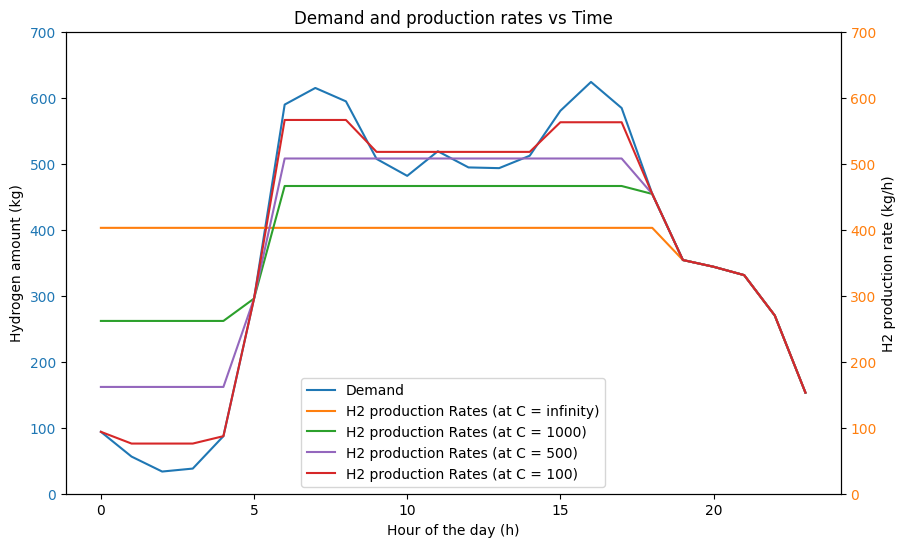

In [24]:
# Model Execution

r_l_inf = opt_prod_rt(np.inf)
r_l_1000 = opt_prod_rt(1000)
r_l_500 = opt_prod_rt(500)
r_l_100 = opt_prod_rt(100)

t = np.array(range(0, h2_demands.shape[0]))

print("Sum demands = " + str(np.sum(h2_demands)))
print("Sum res = " + str(np.sum(r_l_inf)))
print("Sum res = " + str(np.sum(r_l_1000)))
print("Sum res = " + str(np.sum(r_l_500)))
print("Sum res = " + str(np.sum(r_l_100)))

'''
plt.figure(figsize = (10, 6))
plt.plot(t, h2_demands, label = "Demand")
# plt.plot(t, r_l_inf, label = "Rates")
plt.xlabel("Hour of the day (H)")
plt.ylabel("Hydrogen amount (kg)")
plt.title("Demand vs Time")
plt.legend()
# plt.savefig("demands.png", dpi = 300)
'''

fig, ax1 = plt.subplots(figsize = (10, 6))

color = "tab:blue"

ax1.set_xlabel("Hour of the day (h)")
ax1.set_ylabel("Hydrogen amount (kg)")
ax1.plot(t, h2_demands, label = "Demand", color = color)
# ax1.plot(t, r_l_inf, label = "H2 production Rates", color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

# ax1.legend(loc = "upper left")

ax1.set_ylim(0, 700)

ax2 = ax1.twinx()

color2 = "tab:orange"

ax2.set_ylabel("H2 production rate (kg/h)")
ax2.plot(t, r_l_inf, label = "H2 production Rates (at C = infinity)", color = color2)
# ax2.plot(t, np.full(t.shape[0], np.sum(h2_demands)/h2_demands.shape[0]), label = "Average production rate", color = "tab:green")
ax2.plot(t, r_l_1000, label = "H2 production Rates (at C = 1000)", color = "tab:green")
ax2.plot(t, r_l_500, label = "H2 production Rates (at C = 500)", color = "tab:purple")
ax2.plot(t, r_l_100, label = "H2 production Rates (at C = 100)", color = "tab:red")
ax2.tick_params(axis = 'y', labelcolor = color2)

ax2.set_ylim(0, 700)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc = "lower center")

# fig.tight_layout()
plt.title("Demand and production rates vs Time")

# plt.savefig("two_days.png", dpi = 300)


## Simulation with Results

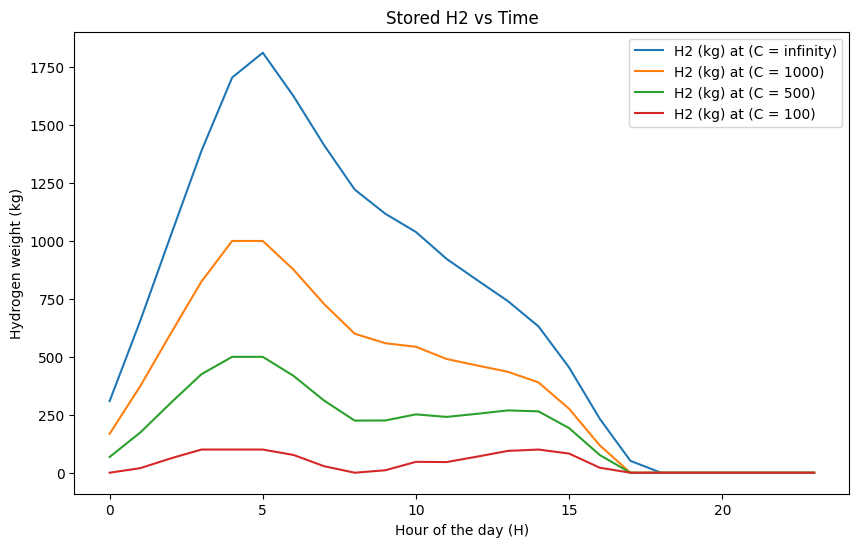

In [25]:
# Simulation with Results

def sim_h2_levels(rates_in):
    sim_H2_level = 0
    h2_level_arr = []
    # print(result.x.shape[0])
    
    for indx in range(0, rates_in.shape[0]):
        sim_H2_level += rates_in[indx]
        sim_H2_level -= h2_demands[indx]
        h2_level_arr.append(sim_H2_level)
        # print(sim_H2_level)
    return h2_level_arr

# print(sim_h2_levels(r_l_inf))
plt.figure(figsize = (10, 6))
plt.plot(t, sim_h2_levels(r_l_inf), label = "H2 (kg) at (C = infinity)")
plt.plot(t, sim_h2_levels(r_l_1000), label = "H2 (kg) at (C = 1000)")
plt.plot(t, sim_h2_levels(r_l_500), label = "H2 (kg) at (C = 500)")
plt.plot(t, sim_h2_levels(r_l_100), label = "H2 (kg) at (C = 100)")
# plt.plot(t, r_l_inf, label = "Rates")
plt.xlabel("Hour of the day (H)")
plt.ylabel("Hydrogen weight (kg)")
plt.title("Stored H2 vs Time")
plt.legend(loc = "upper right")
# plt.savefig("sim_initial_h2_levels.png", dpi = 300)
